## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. 

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

### Q1. 

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [2]:
import pickle
with open('data/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
    
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens. 

What do you notice about the frequency of occurrence of different tokens? How does it look?

The histogram shows that most words appear very few times, while a small number of words occur very often. This makes the distribution highly skewed to the right. It means that the dataset contains many rare or unique words and only a few common ones. 

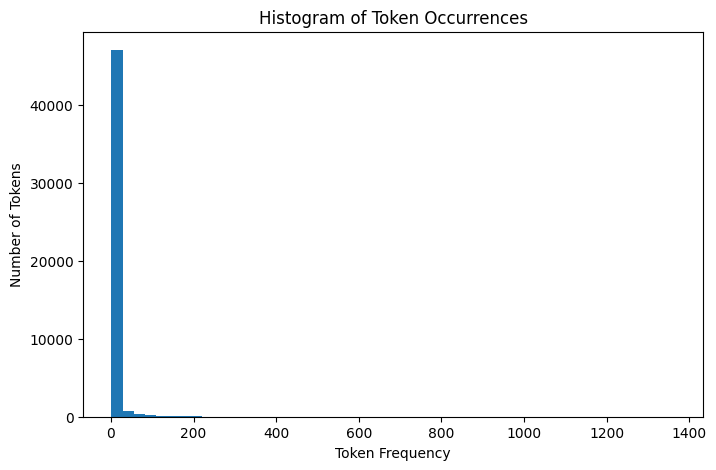

In [3]:
import matplotlib.pyplot as plt

# Get token frequencies (just the counts)
counts = [count for token, count in token_freq]

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(counts, bins=50)
plt.title("Histogram of Token Occurrences")
plt.xlabel("Token Frequency")
plt.ylabel("Number of Tokens")
plt.show()


### Q2. 

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions? 

The words with the largest absolute coefficients are “background-image:”, “localized,”, “thermal,”, “#331f30;,”, and “#000000;.”

Words like “localized,” “thermal,” “erectile,” “girlfriend,” and “xanax” have strong positive effects, meaning they make an email more likely to be classified as a scam. Words like “background-image:” and “cnet” have strong negative effects, meaning they make an email more likely to be legitimate.

In [4]:
#1

import pyarrow.parquet as pq
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Read parquet file directly with pyarrow (bypasses extension issues)
table = pq.read_table('data/Phishing_clean.parquet')
df = table.to_pandas(ignore_metadata=True)

# Step 2: Define X (features) and y (target)
X = df.drop(columns=['Email Type'])
y = df['Email Type']

# Step 3: Perform 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (14907, 2711)
Test set shape: (3727, 2711)


In [5]:
#2

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Fit linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on both training and test sets
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Compute R2 scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R2 on training set: {r2_train:.4f}")
print(f"R2 on test set: {r2_test:.4f}")


R2 on training set: 0.7713
R2 on test set: 0.6424


In [7]:
#3

import numpy as np
import pandas as pd

# Get feature names (all the token columns)
feature_names = X_train.columns

# Get model coefficients
coef = lr.coef_

# Create a DataFrame for easy viewing
coef_df = pd.DataFrame({
    'token': feature_names,
    'coefficient': coef,
    'abs_value': np.abs(coef)
})

# Sort by absolute coefficient value
top_tokens = coef_df.sort_values('abs_value', ascending=False).head(15)
print(top_tokens)


                  token  coefficient  abs_value
1504  background-image:    -1.016799   1.016799
740           localized     0.839522   0.839522
2362            thermal     0.699684   0.699684
2666           #331f30;     0.615728   0.615728
2094           #000000;     0.615728   0.615728
1839              form.     0.593718   0.593718
906               aging     0.586465   0.586465
1302           erectile     0.538953   0.538953
2077         girlfriend     0.527557   0.527557
2532             xanaax     0.516449   0.516449
818                cnet    -0.503287   0.503287
2657              zdnet    -0.449120   0.449120
1637               para     0.415604   0.415604
2361               fax,     0.407003   0.407003
1810          exercise!     0.402741   0.402741


### Q3. 

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

In the PCA scatter plot, there is some separation between phishing and non-phishing emails, but also a lot of overlap. Phishing emails tend to cluster slightly along one side of the first principal component, showing that they share similar word patterns or structures. Non-phishing emails are spread more widely, suggesting they use more varied language. Overall, the two groups are not completely distinct, meaning their vocabularies overlap but still show small differences that the PCA captures.

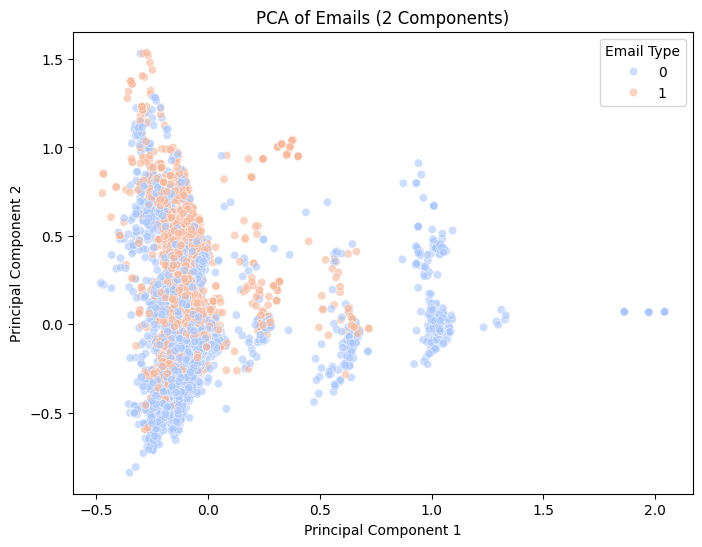

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Perform PCA with two components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame for plotting
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Email Type': y
})

# Scatter plot of the two principal components
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Email Type', palette='coolwarm', alpha=0.6)
plt.title('PCA of Emails (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

The PCA model performs slightly worse than the original linear regression on both the training and test sets.

The training R2 dropped from near-perfect in the full model to 0.77, meaning PCA reduced some overfitting by simplifying the data. The test R2 0.64, which is lower than the full model’s test score, showing a small loss in predictive accuracy. Overall, PCA made the model more compact and stable but sacrificed some power.

In [9]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Perform PCA with 2610 components
pca = PCA(n_components=2610)
X_pca = pca.fit_transform(X)

# Split PCA-transformed data
X_train_pca, X_test_pca, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# Fit linear regression on PCA components
lr_pca = LinearRegression()
lr_pca.fit(X_train_pca, y_train)

# Predict
y_train_pred = lr_pca.predict(X_train_pca)
y_test_pred = lr_pca.predict(X_test_pca)

# Compute R2 scores
r2_train_pca = r2_score(y_train, y_train_pred)
r2_test_pca = r2_score(y_test, y_test_pred)

print(f"R2 (train, PCA): {r2_train_pca:.4f}")
print(f"R2 (test, PCA): {r2_test_pca:.4f}")


R2 (train, PCA): 0.7707
R2 (test, PCA): 0.6441


### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

Using principal components instead of the original data helps make the model more efficient and stable. It removes redundant and highly correlated features, reducing noise and overfitting. It also lowers the number of predictors, making computation faster and improving generalization to new data. In short, PCA simplifies the data while keeping most of the important variation, leading to a more robust model in high-dimensional settings.